In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/')

from Dataset_Creation import sys_dataset


## Read dataset

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}
spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : v_4KJ-ot 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361088.34
  Predicted background counts     : 360331.34
  Predicted excess counts         : 757.00

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -921353.67

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawS

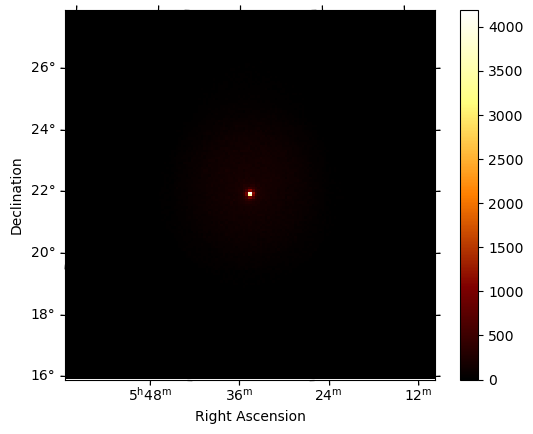

In [3]:
import json
with open("/home/katrin/Documents/nuisance_summary/E_reco/config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",  
    lamda_ = "0.1 TeV-1")
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

bias = [-0.1, 0.0, 0.1]
sigma = 0.0


datasets = []
datasets_N = []

for b in bias:

    sys = sys_dataset(dataset_asimov= dataset_asimov,
                            shift = 0, 
                            tilt = 0,
                              bias = b, 
                             sigma = sigma,
                            rnd = False,
                     e_reco_creation=10,
                     cutoff = True)
    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/b_**2, 1/zero**2])

    dataset = sys.create_dataset()
    dataset_N = sys.create_dataset_N(e_reco_n = 10)
    dataset_N.models.parameters['resolution'].frozen = True

    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix


    for p in ['amplitude', 'norm', 'tilt', 'sigma']:
        dataset_N.models.parameters[p].frozen = True
        dataset.models.parameters[p].frozen = True

    datasets.append(dataset)
    datasets_N.append(dataset_N)



in map: 0.0
evaluate: 0.0 -0.1
10
in map: 0.0
evaluate: 0.0 -0.1
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.1
10
in map: 0.0
evaluate: 0.0 0.1
10


In [5]:
%%time
fits = []
for dataset in datasets:
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(dataset)
    print(result)
    
    fits.append(fit)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 106
	total stat : -752489.19

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 76
	total stat : -752491.55

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 92
	total stat : -752490.88

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 3.88 s, sys: 53.1 ms, total: 3.94 s
Wall time: 3.93 s


In [6]:
%%time
fits_N = []
for dataset_N in datasets_N:
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(dataset_N)
    fits_N.append(fit_N)

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.4235643843096614
10
in map: 0.0
evaluate: 0.0 -0.4235643843096614
10
in map: 0.0
evaluate: 0.0 0.04235643843096615
10
in map: 0.0
evaluate: 0.0 -0.04235643843096615
10
in map: 0.0
evaluate: 0.0 0.012532178120770059
10
in map: 0.0
evaluate: 0.0 -0.012532178120770059
10
in map: 0.0
evaluate: 0.0 0.04235644035427288
10
in map: 0.0
evaluate: 0.0 -0.04235644035427288
10
in map: 0.0
evaluate: 0.0 0.01253217863999473
10
in map: 0.0
evaluate: 0.0 -0.01253217863999473
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.012532178639994

in map: 0.0
evaluate: 0.0 0.03476800573333215
10
in map: 0.0
evaluate: 0.0 0.06880314656091376
10
in map: 0.0
evaluate: 0.0 0.03789835953140878
10
in map: 0.0
evaluate: 0.0 0.06647234644226897
10
in map: 0.0
evaluate: 0.0 0.04022915965005357
10
in map: 0.0
evaluate: 0.0 0.053348514698154284
10
in map: 0.0
evaluate: 0.0 0.0533493224507414
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.0734550459575242
10
in map: 0.0
evaluate: 0.0 0.03324302034708624
10
in map: 0.0
evaluate: 0.0 0.0697863092623355
10
in map: 0.0
evaluate: 0.0 0.03691175704227493
10
in map: 0.0
evaluate: 0.0 0.06713570183919343
10
in map: 0.0
evaluate: 0.0 0.039562364465417006
10
in map: 0.0
evaluate: 0.0 0.0650985386656099
10
in map: 0.0
evaluate: 0.0 0.041599527639000544
10
in map: 0.0
evaluate:

in map: 0.0
evaluate: 0.0 0.06856233098578843
10
in map: 0.0
evaluate: 0.0 0.03813573531882201
10
in map: 0.0
evaluate: 0.0 0.06046351074539596
10
in map: 0.0
evaluate: 0.0 0.05491302127823257
10
in map: 0.0
evaluate: 0.0 0.053706799620341916
10
in map: 0.0
evaluate: 0.0 0.05343160246887123
10
in map: 0.0
evaluate: 0.0 0.0533681282931425
10
in map: 0.0
evaluate: 0.0 0.05335345110169989
10
in map: 0.0
evaluate: 0.0 0.05335005534326436
10
in map: 0.0
evaluate: 0.0 0.0533492696897462
10
in map: 0.0
evaluate: 0.0 0.053349087825426696
10
in map: 0.0
evaluate: 0.0 0.053349045804053696
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluate: 0.0 0.06856233098578843
10
in map: 0.0
evaluate: 0.0 0.03813573531882201
10
in map: 0.0
evaluate: 0.0 0.05334903315230522
10
in map: 0.0
evaluat

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 2.9950643170857685e-13
10
in map: 0.0
evaluate: 0.0 -2.9950643170857685e-13
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 4.235660384359053e-05
10
in map: 0.0
evaluate: 0.0 4.235660384359053e-05
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.4235653591775782
10
in map: 0.0
evaluate: 0.0 -0.4235653591775782
10
in 

in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.0064560810641020525
10
in map: 0.0
evaluate: 0.0 -0.04114851088526311
10
in map: 0.0
evaluate: 0.0 -0.0008594521062922807
10
in map: 0.0
evaluate: 0.0 -0.033832977714868775
10
in map: 0.0
evaluate: 0.0 -0.02942313457962438
10
in map: 0.0
evaluate: 0.0 -0.020822521229588237
10
in map: 0.0
evaluate: 0.0 -0.01856042996482957
10
in map: 0.0
evaluate: 0.0 -0.017803846132264118
10
in map: 0.0
evaluate: 0.0 -0.01752335853561837
10
in map: 0.0
evaluate: 0.0 -0.01741547860769823
10
in map: 0.0
evaluate: 0.0 -0.017373402660553

in map: 0.0
evaluate: 0.0 -0.017361075054567472
10
in map: 0.0
evaluate: 0.0 -0.017351870917436504
10
in map: 0.0
evaluate: 0.0 -0.017348368756975957
10
in map: 0.0
evaluate: 0.0 -0.017347035291605778
10
in map: 0.0
evaluate: 0.0 -0.017346527454511276
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.0029072716909465737
10
in map: 0.0
evaluate: 0.0 -0.03759970151210763
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.017346214910580

In [7]:
fits[0].minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.525e+05                 │              Nfcn = 106              │
│ EDM = 3.24e-07 (Goal: 0.0002)    │            time = 1.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name            │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index   │   1.74    │   0.17    │            │            │         │         │       │
│ 1 │ par_001_lambda_ │    2.3    │    0.5    │            │            │         │         │       │
└───┴─────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────────┬─────────────────────────────────┐
│                 │   par_000_index par_001_lambda_ │
├─────────────────┼─────────────────────────────────┤
│   par_000_index │          0.0273          -0.068 │
│ par_001_lambda_ │          -0.068           0.245 │
└─────────────────┴─────────────────────────────────┘

In [8]:
fits_N[0].minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.525e+05                 │              Nfcn = 447              │
│ EDM = 0.0187 (Goal: 0.0002)      │           time = 139.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name            │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index   │   2.00    │   0.17    │            │            │         │         │       │
│ 1 │ par_001_lambda_ │    1.7    │    0.5    │            │            │         │         │       │
│ 2 │ par_002_bias    │   0.053   │   0.033   │            │            │         │         │       │
└───┴─────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────────┬─────────────────────────────────────────────────┐
│                 │   par_000_index par_001_lambda_    par_002_bias │
├─────────────────┼─────────────────────────────────────────────────┤
│   par_000_index │           0.028         -0.0641        0.000991 │
│ par_001_lambda_ │         -0.0641           0.224       -0.000755 │
│    par_002_bias │        0.000991       -0.000755         0.00107 │
└─────────────────┴─────────────────────────────────────────────────┘

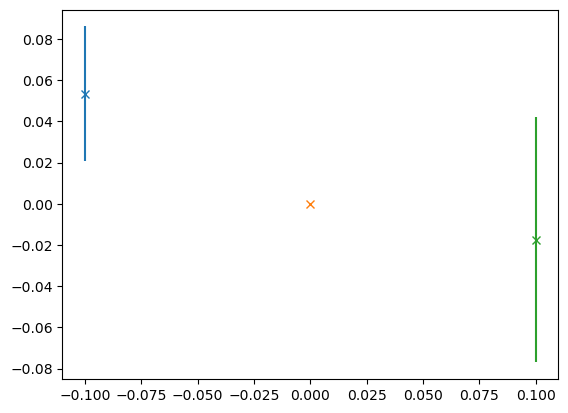

In [9]:
for i, d in enumerate( datasets_N):
    value = d.irf_model.parameters['bias'].value
    error = d.irf_model.parameters['bias'].error
    plt.errorbar(bias[i], value, yerr = error, fmt = 'x')
    

## Stat Profiles for Source Index

In [16]:
%%time
computing_index = 0

if computing_index:
    sigma = 2
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

FileNotFoundError: [Errno 2] No such file or directory: 'data/5_scan_index.yaml'

# Stat Contours

In [10]:
%%time
xs, ys, ss = [], [], []
xs_N, ys_N, ss_N = [], [], []

for fit in fits:
    ## mn profile reoptimizes and profile does not
    x, y, s = fit.minuit.mnprofile("par_000_index", size = 11, bound = 4)
    xs.append(x); ys.append(y); ss.append(s)

for fit_N in fits_N:
    x_N, y_N , s_N= fit_N.minuit.mnprofile("par_000_index", size = 11, bound = 4)
    xs_N.append(x_N); ys_N.append(y_N); ss_N.append(s_N)
print(x_N, y_N , s_N)



in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.06721398032143099
10
in map: 0.0
evaluate: 0.0 0.03946620840796647
10
in map: 0.0
evaluate: 0.0 0.05716856326010981
10
in map: 0.0
evaluate: 0.0 0.04951162546928765
10
in map: 0.0
evaluate: 0.0 0.05474465653429174
10
in map: 0.0
evaluate: 0.0 0.051935532195105716
10
in map: 0.0
evaluate: 0.0 0.053855145367407896
10
in map: 0.0
evaluate: 0.0 0.05282504336198956
10
in map: 0.0
evaluate: 0.0 0.053528950767769194
10
in map: 0.0
evaluate: 0.0 0.05315123796162826
10
in map: 0.0
evaluate: 0.0 0.05315123796162826
10
in map: 0.0
evaluate: 0.0 0.05239581234934638
10
in map: 0.0
evaluate: 0.0 0.0527731724616478
10
in map: 0.0
evaluate: 0.0 0.05050724831864168
10
in map: 0.0
evaluate: 0.0 0.04484155622652758
10
in map: 0.0
evalua

in map: 0.0
evaluate: 0.0 0.0031142517742336778
10
in map: 0.0
evaluate: 0.0 0.0031142517742336778
10
in map: 0.0
evaluate: 0.0 0.0031142517742336778
10
in map: 0.0
evaluate: 0.0 0.01606752280216094
10
in map: 0.0
evaluate: 0.0 -0.009839019253693583
10
in map: 0.0
evaluate: 0.0 0.018474810920892145
10
in map: 0.0
evaluate: 0.0 -0.012246307372424789
10
in map: 0.0
evaluate: 0.0 0.020861575508539853
10
in map: 0.0
evaluate: 0.0 -0.014633071960072496
10
in map: 0.0
evaluate: 0.0 0.014059226578964804
10
in map: 0.0
evaluate: 0.0 -0.00783072303049745
10
in map: 0.0
evaluate: 0.0 0.016344525777411065
10
in map: 0.0
evaluate: 0.0 -0.01011602222894371
10
in map: 0.0
evaluate: 0.0 -0.0031322311708609648
10
in map: 0.0
evaluate: 0.0 -0.0010311205092866835
10
in map: 0.0
evaluate: 0.0 -0.0024284178474632888
10
in map: 0.0
evaluate: 0.0 -0.0024284178474632888
10
in map: 0.0
evaluate: 0.0 -0.0024284178474632888
10
in map: 0.0
evaluate: 0.0 0.013216217422678346
10
in map: 0.0
evaluate: 0.0 -0.018073

in map: 0.0
evaluate: 0.0 0.0021212073900091005
10
in map: 0.0
evaluate: 0.0 0.044477743180299456
10
in map: 0.0
evaluate: 0.0 -0.04023532840028125
10
in map: 0.0
evaluate: 0.0 0.01643423455716644
10
in map: 0.0
evaluate: 0.0 -0.012191819777148241
10
in map: 0.0
evaluate: 0.0 0.11107197435127293
10
in map: 0.0
evaluate: 0.0 -0.10682955957125474
10
in map: 0.0
evaluate: 0.0 0.019857191263957265
10
in map: 0.0
evaluate: 0.0 -0.015614776483939063
10
in map: 0.0
evaluate: 0.0 0.012533276642111943
10
in map: 0.0
evaluate: 0.0 -0.008290861862093744
10
in map: 0.0
evaluate: 0.0 0.002080345170148679
10
in map: 0.0
evaluate: 0.0 0.0021093845438008834
10
in map: 0.0
evaluate: 0.0 0.0021162993817917773
10
in map: 0.0
evaluate: 0.0 0.0021189338968737913
10
in map: 0.0
evaluate: 0.0 0.0021201056978620127
10
in map: 0.0
evaluate: 0.0 0.002120662599080815
10
in map: 0.0
evaluate: 0.0 0.0021209310472480192
10
in map: 0.0
evaluate: 0.0 0.0021209310472480192
10
in map: 0.0
evaluate: 0.0 0.00212093104724

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.7336447187540487
  warnings.warn(


in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.06721504716215082
10
in map: 0.0
evaluate: 0.0 0.039465141567246634
10
in map: 0.0
evaluate: 0.0 0.07454410630815858
10
in map: 0.0
evaluate: 0.0 0.032136082421238873
10
in map: 0.0
evaluate: 0.0 0.09306737842434877
10
in map: 0.0
evaluate: 0.0 0.013612810305048684
10
in map: 0.0
evaluate: 0.0 0.04743410347917006
10
in map: 0.0
evaluate: 0.0 0.048985058385803484
10
in map: 0.0
evaluate: 0.0 0.048985058385803484
10
in map: 0.0
evaluate: 0.0 0.048985058385803484
10
in map: 0.0
evaluate: 0.0 0.048985058385803484
10
in map: 0.0
evaluate: 0.0 0.048985058385803484
10
in map: 0.0
evaluate: 0.0 0.07556766711045623
10
in map: 0.0
evaluate: 0.0 0.022402449661150736
10
in map: 0.0
evaluate: 0.0 0.045962266381890236
10
in map: 0.

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.8674051424633797
  warnings.warn(


in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.06721506853083124
10
in map: 0.0
evaluate: 0.0 0.039465120198566205
10
in map: 0.0
evaluate: 0.0 0.06515926592998539
10
in map: 0.0
evaluate: 0.0 0.041520922799412066
10
in map: 0.0
evaluate: 0.0 0.07164494155753308
10
in map: 0.0
evaluate: 0.0 0.035035247171864375
10
in map: 0.0
evaluate: 0.0 0.06850182485483686
10
in map: 0.0
evaluate: 0.0 0.038178363874560604
10
in map: 0.0
evaluate: 0.0 0.06615887507646591
10
in map: 0.0
evaluate: 0.0 0.04052131365293154
10
in map: 0.0
evaluate: 0.0 0.050301054154388326
10
in map: 0.0
evaluate: 0.0 0.05308485071632435
10
in map: 0.0
evaluate: 0.0 0.05332733218228001
10
in map: 0.0
evaluate: 0.0 0.05333945625557779
10
in map: 0.0
evaluate: 0.0 0.05333945625557779
10
in map: 0.0
eva

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.001165566172711
  warnings.warn(


in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.06721505295260834
10
in map: 0.0
evaluate: 0.0 0.03946513577678912
10
in map: 0.0
evaluate: 0.0 0.06156518089478723
10
in map: 0.0
evaluate: 0.0 0.04511500783461023
10
in map: 0.0
evaluate: 0.0 0.05480967797890787
10
in map: 0.0
evaluate: 0.0 0.055561636860279845
10
in map: 0.0
evaluate: 0.0 0.05524426920837351
10
in map: 0.0
evaluate: 0.0 0.05524426920837351
10
in map: 0.0
evaluate: 0.0 0.05524426920837351
10
in map: 0.0
evaluate: 0.0 0.05524426920837351
10
in map: 0.0
evaluate: 0.0 0.05524426920837351
10
in map: 0.0
evaluate: 0.0 0.06287139799406538
10
in map: 0.0
evaluate: 0.0 0.04761714042268164
10
in map: 0.0
evaluate: 0.0 0.0646152573472233
10
in map: 0.0
evaluate: 0.0 0.04587328106952372
10
in map: 0.0
evaluate

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.134925989882042
  warnings.warn(


in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.0672150152286085
10
in map: 0.0
evaluate: 0.0 0.03946517350078896
10
in map: 0.0
evaluate: 0.0 0.06022968439964378
10
in map: 0.0
evaluate: 0.0 0.04645050432975367
10
in map: 0.0
evaluate: 0.0 0.058476853416682094
10
in map: 0.0
evaluate: 0.0 0.04820333531271536
10
in map: 0.0
evaluate: 0.0 0.05718254243976198
10
in map: 0.0
evaluate: 0.0 0.049497646289635475
10
in map: 0.0
evaluate: 0.0 0.05621958288382165
10
in map: 0.0
evaluate: 0.0 0.0504606058455758
10
in map: 0.0
evaluate: 0.0 0.09621308172546472
10
in map: 0.0
evaluate: 0.0 0.09621308172546472
10
in map: 0.0
evaluate: 0.0 0.09621308172546472
10
in map: 0.0
evaluate: 0.0 0.09621308172546472
10
in map: 0.0
evaluate: 0.0 0.09621308172546472
10
in map: 0.0
evaluate: 0.0 0.09837313453046892
10
in map: 0.0
evaluate: 0.0 0.09405302892046052
10
in map: 0.0
evaluate

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.2686864135913734
  warnings.warn(


in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.06721496514722401
10
in map: 0.0
evaluate: 0.0 0.03946522358217344
10
in map: 0.0
evaluate: 0.0 0.05949820973267676
10
in map: 0.0
evaluate: 0.0 0.04718197899672069
10
in map: 0.0
evaluate: 0.0 0.05736755459098778
10
in map: 0.0
evaluate: 0.0 0.049312634138409674
10
in map: 0.0
evaluate: 0.0 0.05598092863692343
10
in map: 0.0
evaluate: 0.0 0.050699260092474024
10
in map: 0.0
evaluate: 0.0 0.05507362992735008
10
in map: 0.0
evaluate: 0.0 0.05160655880204738
10
in map: 0.0
evaluate: 0.0 0.16185483243851811
10
in map: 0.0
evaluate: 0.0 0.12358062165566999
10
in map: 0.0
evaluate: 0.0 0.1842610117029247
10
in map: 0.0
evaluate: 0.0 0.1842610117029247
10
in map: 0.0
evaluate: 0.0 0.1842610117029247
10
in map: 0.0
evaluate:

in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.11219469438375879
10
in map: 0.0
evaluate: 0.0 0.10227766288534998
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10723617863455438
10
in map: 0.0
evaluate: 0.0 0.10822788178439527
10
in map: 0.0
evaluate: 0.0 0.1062444754847135
10
in map: 0.0
evaluate: 0.0 0.10743451926452256
10
in map: 0.0
evaluate: 0.0 0.1070378380045862
10
in map: 0.0
evaluate: 0.0 0.10727584676054802
10
in map: 0.0
evaluate: 0.0 0.10719651050856074
10
in map: 0.0
evaluate: 0.0 0.11219469438375879
10


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.402446837300704
  warnings.warn(


in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.06721490901032619
10
in map: 0.0
evaluate: 0.0 0.039465279719071274
10
in map: 0.0
evaluate: 0.0 0.05902177221959594
10
in map: 0.0
evaluate: 0.0 0.047658416509801516
10
in map: 0.0
evaluate: 0.0 0.056731956116524554
10
in map: 0.0
evaluate: 0.0 0.0499482326128729
10
in map: 0.0
evaluate: 0.0 0.055369167833278485
10
in map: 0.0
evaluate: 0.0 0.05131102089611897
10
in map: 0.0
evaluate: 0.0 0.05455481842602257
10
in map: 0.0
evaluate: 0.0 0.052125370303374885
10
in map: 0.0
evaluate: 0.0 0.25071323993155453
10
in map: 0.0
evaluate: 0.0 0.1597806617898909
10
in map: 0.0
evaluate: 0.0 0.20098306580045613
10
in map: 0.0
evaluate: 0.0 0.20098306580045613
10
in map: 0.0
evaluate: 0.0 0.20098306580045613
10
in map: 0.0
evalu

in map: 0.0
evaluate: 0.0 0.09259818347874602
10
in map: 0.0
evaluate: 0.0 0.10998572435326456
10
in map: 0.0
evaluate: 0.0 0.10933431479779782
10
in map: 0.0
evaluate: 0.0 0.10919895875845285
10
in map: 0.0
evaluate: 0.0 0.1091545841471667
10
in map: 0.0
evaluate: 0.0 0.10913812101974688
10
in map: 0.0
evaluate: 0.0 0.10913173947442922
10
in map: 0.0
evaluate: 0.0 0.1091292242353698
10
in map: 0.0
evaluate: 0.0 0.10912822630361256
10
in map: 0.0
evaluate: 0.0 0.10912782935493462
10
in map: 0.0
evaluate: 0.0 0.10912767135105529
10
in map: 0.0
evaluate: 0.0 0.10912760830400513
10
in map: 0.0
evaluate: 0.0 0.10912756655700942
10
in map: 0.0
evaluate: 0.0 0.10912756655700942
10
in map: 0.0
evaluate: 0.0 0.10912756655700942
10
in map: 0.0
evaluate: 0.0 0.12565694963527282
10
in map: 0.0
evaluate: 0.0 0.09259818347874602
10
in map: 0.0
evaluate: 0.0 0.10912756655700942
10
in map: 0.0
evaluate: 0.0 0.10912756655700942
10
in map: 0.0
evaluate: 0.0 0.10912756655700942
10
in map: 0.0
evaluate: 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.536207261010035
  warnings.warn(


in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.05334009436469873
10
in map: 0.0
evaluate: 0.0 0.0672148507253243
10
in map: 0.0
evaluate: 0.0 0.03946533800407316
10
in map: 0.0
evaluate: 0.0 0.05867572149373479
10
in map: 0.0
evaluate: 0.0 0.048004467235662665
10
in map: 0.0
evaluate: 0.0 0.0563108598441737
10
in map: 0.0
evaluate: 0.0 0.05036932888522375
10
in map: 0.0
evaluate: 0.0 0.05499696878301661
10
in map: 0.0
evaluate: 0.0 0.051683219946380844
10
in map: 0.0
evaluate: 0.0 0.054264664496693045
10
in map: 0.0
evaluat

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 4.235654330313107e-13
10
in map: 0.0
evaluate: 0.0 -4.235654330313107e-13
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 4.2356544704469474e-13
10
in map: 0.0
evaluate: 0.0 -4.2356544704469474e-13
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 4.2356544704469474e-13
10
in map: 0.0
evaluate: 0.0 -4.2356544704469474e-13
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 4.23565806386269e-13
10
in map: 0.0
evaluate: 0.0 -4.23565806386269e-13
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 8.47131612772538e-14
10
in map: 0.0
evaluate: 0.0 -8.47131612772538e-14
10
in map: 0.0
evaluate: 0.0 4.23565806386269e-13
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 

in map: 0.0
evaluate: 0.0 0.07114241135270567
10
in map: 0.0
evaluate: 0.0 0.07114241135270567
10
in map: 0.0
evaluate: 0.0 0.07114241135270567
10
in map: 0.0
evaluate: 0.0 0.07114241135270567
10
in map: 0.0
evaluate: 0.0 0.07399611202142213
10
in map: 0.0
evaluate: 0.0 0.06828871068398921
10
in map: 0.0
evaluate: 0.0 0.0996794180398703
10
in map: 0.0
evaluate: 0.0 0.04260540466554105
10
in map: 0.0
evaluate: 0.0 0.11159126303548708
10
in map: 0.0
evaluate: 0.0 0.030693559669924257
10
in map: 0.0
evaluate: 0.0 0.08894779390778793
10
in map: 0.0
evaluate: 0.0 0.05333702879762342
10
in map: 0.0
evaluate: 0.0 0.083131570807019
10
in map: 0.0
evaluate: 0.0 0.05915325189839235
10
in map: 0.0
evaluate: 0.0 -0.05146819718166397
10
in map: 0.0
evaluate: 0.0 -0.06367089934290214
10
in map: 0.0
evaluate: 0.0 -0.06367089934290214
10
in map: 0.0
evaluate: 0.0 -0.06367089934290214
10
in map: 0.0
evaluate: 0.0 -0.05541522148015074
10
in map: 0.0
evaluate: 0.0 -0.07192657720565354
10
in map: 0.0
eval

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.7532105017912238
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.007926200980659697
10
in map: 0.0
evaluate: 0.0 -0.04261863080182075
10
in map: 0.0
evaluate: 0.0 -0.0026672767263931484
10
in map: 0.0
evaluate: 0.0 -0.03202515309476791
10
in map: 0.0
evaluate: 0.0 0.17815975827027458
10
in map: 0.0
evaluate: 0.0 0.08255190012839424
10
in map: 0.0
evaluate: 0.0 0.08255190012839424
10
in map: 0.0
evaluate: 0.0 0.08255190012839424
10
in map: 0.0
evaluate: 0.0 0.08255190012839424
10
in map: 0.0
evaluate: 0.0 0.08255190012839424
10
in map: 0.0
evaluate: 0.0 0.08598740103967746
10
in map: 0.0
evaluate: 0.0 0.07911639921711101
10
in map: 0.0
evaluate: 0.0 -0.020178065147698307
10
in map: 0.0
evaluate: 0.0 -0.020178065147698307
10
in map: 0.0
evaluate: 0.0 -0.020178065147698307
10
in 

in map: 0.0
evaluate: 0.0 -0.060590757478096925
10
in map: 0.0
evaluate: 0.0 -0.06803248725387735
10
in map: 0.0
evaluate: 0.0 -0.06088842666912814
10
in map: 0.0
evaluate: 0.0 -0.06446045696150274
10
in map: 0.0
evaluate: 0.0 -0.06624647210769005
10
in map: 0.0
evaluate: 0.0 -0.0671394796807837
10
in map: 0.0
evaluate: 0.0 -0.0671394796807837
10
in map: 0.0
evaluate: 0.0 -0.0671394796807837
10
in map: 0.0
evaluate: 0.0 -0.0671394796807837
10
in map: 0.0
evaluate: 0.0 -0.0671394796807837
10
in map: 0.0
evaluate: 0.0 -0.065947605362838
10
in map: 0.0
evaluate: 0.0 -0.06833135399872939
10
in map: 0.0
evaluate: 0.0 -0.06617935400777089
10
in map: 0.0
evaluate: 0.0 -0.0680996053537965
10
in map: 0.0
evaluate: 0.0 -0.06636597155906689
10
in map: 0.0
evaluate: 0.0 -0.0679129878025005
10
in map: 0.0
evaluate: 0.0 -0.06651628018887218
10
in map: 0.0
evaluate: 0.0 -0.06776267917269521
10
in map: 0.0
evaluate: 0.0 -0.06663736167222901
10
in map: 0.0
evaluate: 0.0 -0.06764159768933838
10
in map: 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.9084735419949896
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.007927029614033122
10
in map: 0.0
evaluate: 0.0 -0.042619459435194185
10
in map: 0.0
evaluate: 0.0 -0.001851027664768615
10
in map: 0.0
evaluate: 0.0 -0.032841402156392446
10
in map: 0.0
evaluate: 0.0 -0.012900864147064334
10
in map: 0.0
evaluate: 0.0 -0.021791565674096725
10
in map: 0.0
evaluate: 0.0 -0.01610837328301602
10
in map: 0.0
evaluate: 0.0 -0.01858405653814504
10
in map: 0.0
evaluate: 0.0 -0.004967798634935426
10
in map: 0.0
evaluate: 0.0 -0.029724631186225633
10
in map: 0.0
evaluate: 0.0 0.009202841011999249
10
in map: 0.0
evaluate: 0.0 -0.003256614069381424
10
in map: 0.0
evaluate: 0.0 -0.0018331790880234088
10
in map: 0.0
evaluate: 0.0 -0.012403020170185358
10
in map: 0.0
evaluate: 0.0 -0.0055323419

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


in map: 0.0
evaluate: 0.0 -50.47282907656763
10


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


in map: 0.0
evaluate: 0.0 -24.622007543464633
10


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


in map: 0.0
evaluate: 0.0 -12.187792287523187
10
in map: 0.0
evaluate: 0.0 -6.0882782724528655
10
in map: 0.0
evaluate: 0.0 -3.0673747924841606
10
in map: 0.0
evaluate: 0.0 -1.5641077348607275
10
in map: 0.0
evaluate: 0.0 -0.8142858682315759
10
in map: 0.0
evaluate: 0.0 -0.4398394830512065
10
in map: 0.0
evaluate: 0.0 -0.2529188352238841
10
in map: 0.0
evaluate: 0.0 -0.15974148089809426
10


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.0637365821987554
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.007927456965670866
10
in map: 0.0
evaluate: 0.0 -0.04261988678683193
10
in map: 0.0
evaluate: 0.0 -0.0011270259125697839
10
in map: 0.0
evaluate: 0.0 -0.03356540390859128
10
in map: 0.0
evaluate: 0.0 -0.011412183693945735
10
in map: 0.0
evaluate: 0.0 -0.023280246127215326
10
in map: 0.0
evaluate: 0.0 -0.015227302131927162
10
in map: 0.0
evaluate: 0.0 -0.019465127689233898
10
in map: 0.0
evaluate: 0.0 0.003842912875953154
10
in map: 0.0
evaluate: 0.0 -0.038535342697114214
10
in map: 0.0
evaluate: 0.0 0.022054376332444014
10
in map: 0.0
evaluate: 0.0 0.004993359554852663
10
in map: 0.0
evaluate: 0.0 0.007302469099712137
10
in map: 0.0
evaluate: 0.0 0.004993359554852663
10
in map: 0.0
evaluate: 0.0 0.004993359554852

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.218999622402521
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.00792764296097146
10
in map: 0.0
evaluate: 0.0 -0.04262007278213252
10
in map: 0.0
evaluate: 0.0 -0.0005098667308941866
10
in map: 0.0
evaluate: 0.0 -0.034182563090266876
10
in map: 0.0
evaluate: 0.0 -0.008809188467174697
10
in map: 0.0
evaluate: 0.0 -0.025883241353986362
10
in map: 0.0
evaluate: 0.0 -0.013071050485971356
10
in map: 0.0
evaluate: 0.0 -0.021621379335189705
10
in map: 0.0
evaluate: 0.0 -0.015197084435967494
10
in map: 0.0
evaluate: 0.0 -0.019495345385193565
10
in map: 0.0
evaluate: 0.0 0.027277306099359282
10
in map: 0.0
evaluate: 0.0 0.006520080166229965
10
in map: 0.0
evaluate: 0.0 0.006520080166229965
10
in map: 0.0
evaluate: 0.0 0.006520080166229965
10
in map: 0.0
evaluate: 0.0 0.00652008016622

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3742626626062866
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.007927688574772784
10
in map: 0.0
evaluate: 0.0 -0.04262011839593384
10
in map: 0.0
evaluate: 0.0 -6.7760161078685155e-06
10
in map: 0.0
evaluate: 0.0 -0.03468565380505319
10
in map: 0.0
evaluate: 0.0 -0.024271125871890464
10
in map: 0.0
evaluate: 0.0 -0.0193577347667528
10
in map: 0.0
evaluate: 0.0 -0.01797267831928554
10
in map: 0.0
evaluate: 0.0 -0.01754535904094338
10
in map: 0.0
evaluate: 0.0 -0.01740992669659974
10
in map: 0.0
evaluate: 0.0 -0.01736663947446454
10
in map: 0.0
evaluate: 0.0 -0.017352766763274012
10
in map: 0.0
evaluate: 0.0 -0.017348317036472976
10
in map: 0.0
evaluate: 0.0 -0.017346889254008523
10
in map: 0.0
evaluate: 0.0 -0.017346431297639856
10
in map: 0.0
evaluate: 0.0 -0.01734628437611

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.5295257028100524
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.00792765609249211
10
in map: 0.0
evaluate: 0.0 -0.04262008591365317
10
in map: 0.0
evaluate: 0.0 0.00038377951931089366
10
in map: 0.0
evaluate: 0.0 -0.03507620934047195
10
in map: 0.0
evaluate: 0.0 0.00038377951931089366
10
in map: 0.0
evaluate: 0.0 0.0713037572388766
10
in map: 0.0
evaluate: 0.0 0.02114008019422831
10
in map: 0.0
evaluate: 0.0 0.01267451009678202
10
in map: 0.0
evaluate: 0.0 0.10979005234368544
10
in map: 0.0
evaluate: 0.0 0.06546506626895689
10
in map: 0.0
evaluate: 0.0 0.0433025732315926
10
in map: 0.0
evaluate: 0.0 0.03222132671291046
10
in map: 0.0
evaluate: 0.0 0.015504514483834327
10
in map: 0.0
evaluate: 0.0 0.015504514483834327
10
in map: 0.0
evaluate: 0.0 0.015504514483834327
10
in map: 0.0
evaluate: 0.0 0.03275319398723532
10
in map: 0.0
evaluate: 0.0 -0.0017441650195666666
10
in ma

in map: 0.0
evaluate: 0.0 -0.007904842811141642
10
in map: 0.0
evaluate: 0.0 -0.07630805619839978
10
in map: 0.0
evaluate: 0.0 0.011071433622891258
10
in map: 0.0
evaluate: 0.0 -0.09528433263243269
10
in map: 0.0
evaluate: 0.0 -0.025324515015756062
10
in map: 0.0
evaluate: 0.0 -0.05888838399378537
10
in map: 0.0
evaluate: 0.0 -0.03238842025436247
10
in map: 0.0
evaluate: 0.0 -0.05182447875517896
10
in map: 0.0
evaluate: 0.0 -0.037150491687578016
10
in map: 0.0
evaluate: 0.0 -0.047062407321963415
10
in map: 0.0
evaluate: 0.0 -0.02944071648387025
10
in map: 0.0
evaluate: 0.0 -0.027661879127802082
10
in map: 0.0
evaluate: 0.0 -0.03130973883119985
10
in map: 0.0
evaluate: 0.0 -0.03207820377194762
10
in map: 0.0
evaluate: 0.0 -0.03207820377194762
10
in map: 0.0
evaluate: 0.0 -0.03207820377194762
10
in map: 0.0
evaluate: 0.0 -0.03207820377194762
10
in map: 0.0
evaluate: 0.0 -0.03207820377194762
10
in map: 0.0
evaluate: 0.0 -0.029563487406802345
10
in map: 0.0
evaluate: 0.0 -0.034592920137092

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.840051783217584
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.007927490433119428
10
in map: 0.0
evaluate: 0.0 -0.04261992025428049
10
in map: 0.0
evaluate: 0.0 0.0008666044254247024
10
in map: 0.0
evaluate: 0.0 -0.03555903424658576
10
in map: 0.0
evaluate: 0.0 -0.008616154909634358
10
in map: 0.0
evaluate: 0.0 -0.0260762749115267
10
in map: 0.0
evaluate: 0.0 -0.013416585494595464
10
in map: 0.0
evaluate: 0.0 -0.021275844326565596
10
in map: 0.0
evaluate: 0.0 0.021950079249270126
10
in map: 0.0
evaluate: 0.0 -0.05664250907043118
10
in map: 0.0
evaluate: 0.0 0.021950079249270126
10
in map: 0.0
evaluate: 0.0 0.17913525588867274
10
in map: 0.0
evaluate: 0.0 0.08403134393013259
10
in map: 0.0
evaluate: 0.0 0.07812626963103961
10
in map: 0.0
evaluate: 0.0 0.28678646161155885
10
i

in map: 0.0
evaluate: 0.0 0.040015682275476715
10
in map: 0.0
evaluate: 0.0 0.04001376971324079
10
in map: 0.0
evaluate: 0.0 0.04001316075566983
10
in map: 0.0
evaluate: 0.0 0.04001296695392231
10
in map: 0.0
evaluate: 0.0 0.040012905166557276
10


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.9953148234213494
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.007927390659555264
10
in map: 0.0
evaluate: 0.0 -0.042619820480716324
10
in map: 0.0
evaluate: 0.0 0.0009864934144511658
10
in map: 0.0
evaluate: 0.0 -0.035678923235612225
10
in map: 0.0
evaluate: 0.0 -0.009675192949709175
10
in map: 0.0
evaluate: 0.0 -0.025017236871451885
10
in map: 0.0
evaluate: 0.0 -0.014317804334908198
10
in map: 0.0
evaluate: 0.0 -0.02037462548625286
10
in map: 0.0
evaluate: 0.0 0.0129378908461427

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=3.1505778636251156
  warnings.warn(


in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 0.007927289342232417
10
in map: 0.0
evaluate: 0.0 -0.04261971916339348
10
in map: 0.0
evaluate: 0.0 0.0010446072489777858
10
in map: 0.0
evaluate: 0.0 -0.035737037070138845
10
in map: 0.0
evaluate: 0.0 -0.010391235914291402
10
in map: 0.0
evaluate: 0.0 -0.024301193906869658
10
in map: 0.0
evaluate: 0.0 -0.014857122191092191
10
in map: 0.0
evaluate: 0.0 -0.01983530763006887
10
in map: 0.0
evaluate: 0.0 0.007544712284302858
10
in map: 0.0
evaluate: 0.0 -0.04223714210546392
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.01734621491058053
10
in map: 0.0
evaluate: 0.0 -0.0173462149105805

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=3.305840903828881
  warnings.warn(


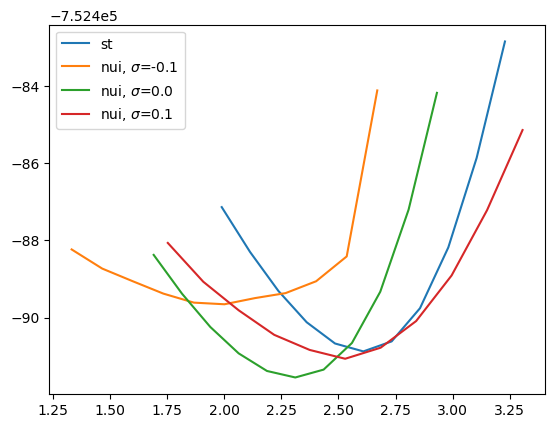

In [14]:
plt.plot(x, y,label = 'st');

for i in range(len(bias)):
    plt.plot(xs_N[i], ys_N[i],label = f'nui, $\sigma$={bias[i]}');
plt.legend()

In [ ]:
grid = np.linspace(-0.04, 0.04, 11)

In [ ]:
for d in datasets_N:
    print("best fit bias:", d.irf_model.parameters['bias'].value)
    print("error bias:", d.irf_model.parameters['bias'].error)
    
    print("Penalty", 1/np.sqrt(d.penalising_invcovmatrix[0][0]))
    print()

In [ ]:
%%time
xs_Nass, ys_Nass, ss_Nass = [], [], []
for fit_N in fits_N:
    x_Nass, y_Nass , s_Nass= fit_N.minuit.mnprofile("par_002_bias", 
                                                    grid = grid)
                                                    #size = 11, bound = 4)
    xs_Nass.append(x_Nass); ys_Nass.append(y_Nass); ss_Nass.append(s_Nass)
print(x_Nass, y_Nass , s_Nass)

In [ ]:
i = 0
plt.plot(xs_Nass[i], ys_Nass[i],label = f'nui, $\sigma$={bias[i]}');


In [ ]:
i = 1
plt.plot(xs_Nass[i], ys_Nass[i],label = f'nui, $\sigma$={bias[i]}');


In [ ]:
i = 2
plt.plot(xs_Nass[i], ys_Nass[i],label = f'nui, $\sigma$={bias[i]}');


In [ ]:
%%time
xs_Nass_b2, ys_Nass_b2, ss_Nass_b2 = [], [], []
for fit_N in fits_N:
    x_Nass_b2, y_Nass_b2 , s_Nass_b2= fit_N.minuit.mnprofile("par_001_resolution", size = 11, bound = 2)
    xs_Nass_b2.append(x_Nass_b2); ys_Nass_b2.append(y_Nass_b2); ss_Nass_b2.append(s_Nass_b2)
print(x_Nass_b2, y_Nass_b2 , s_Nass_b2)

In [ ]:
fig, axs = plt.subplots(2,3)

for i in range(len(sigmass)):
    axs.flatten()[i].plot(xs_Nass_b2[i], ys_Nass_b2[i],label = f'nui, $\sigma$={sigmass[i]}');
    axs.flatten()[i].legend()

In [ ]:
%%time
mncontour_0 = fits_N[2].minuit.mncontour('par_001_resolution', 'par_000_index', size=20, interpolated=200)

In [ ]:
x, y = np.transpose(mncontour_0)
plt.plot(x, y, "o-");